In [1]:
# Install required packages if not already installed
!pip install mediapipe==0.10.20 opencv-python matplotlib pandas


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [4]:
# Path to your local video
video_path = r"path__to_your_video"
print(os.path.exists(video_path))


True


In [7]:
# Analysis parameters
real_height = 1.70       # performer height in meters (for scale)
smooth_k = 5             # smoothing window
output_prefix = "kalaripayattu"
overlay = True           # create overlay video
write_csv = True
scale_factor = 1.7/800      # will be auto-estimated


In [9]:
def moving_average_with_interp(arr, k):
    arr = np.array(arr, dtype=float)
    if arr.size == 0: return arr
    nans = np.isnan(arr)
    if nans.any() and (~nans).any():
        xp = np.where(~nans)[0]
        fp = arr[~nans]
        arr[nans] = np.interp(np.where(nans)[0], xp, fp)
    if k <= 1: return arr
    return np.convolve(arr, np.ones(k)/k, mode='same')


In [11]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.3,
                    min_tracking_confidence=0.3)

# Landmarks to track
landmark_indices = {
    "Nose": mp_pose.PoseLandmark.NOSE,
    "Left_Ankle": mp_pose.PoseLandmark.LEFT_ANKLE,
    "Right_Ankle": mp_pose.PoseLandmark.RIGHT_ANKLE,
    "Left_Wrist": mp_pose.PoseLandmark.LEFT_WRIST,
    "Right_Wrist": mp_pose.PoseLandmark.RIGHT_WRIST,
}

# Storage for trajectories
trajectories = {name: {"pixels": [], "meters": []} for name in landmark_indices}


In [13]:
def estimate_pixel_height(video_path, calib_frames=200):
    cap = cv2.VideoCapture(video_path)
    heights = []
    frames = 0
    while frames < calib_frames:
        ret, frame = cap.read()
        if not ret: break
        h, w = frame.shape[:2]
        with mp.solutions.pose.Pose(
            static_image_mode=True,
            min_detection_confidence=0.3
        ) as temp_pose:
            res = temp_pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if res.pose_landmarks:
                lm = res.pose_landmarks.landmark
                nose_y = lm[mp_pose.PoseLandmark.NOSE].y * h
                left_ank = lm[mp_pose.PoseLandmark.LEFT_ANKLE].y * h
                right_ank = lm[mp_pose.PoseLandmark.RIGHT_ANKLE].y * h
                pixel_h = max(left_ank, right_ank) - nose_y
                if pixel_h > 10: heights.append(pixel_h)
        frames += 1
    cap.release()
    return float(np.median(heights)) if heights else None

if real_height and scale_factor is None:
    median_pixel_h = estimate_pixel_height(video_path)
    if median_pixel_h:
        scale_factor = real_height / median_pixel_h
        print(f"Estimated scale: {scale_factor:.6f} meters per pixel")
    else:
        print("Scale estimation failed; using pixel units.")

In [15]:
cap = cv2.VideoCapture(video_path)
W, H = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
frame_idx = 0

print("Processing video frames...")
while True:
    ret, frame = cap.read()
    if not ret: break
    res = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    for name, idx in landmark_indices.items():
        if res.pose_landmarks:
            lm = res.pose_landmarks.landmark[idx]
            x_px, y_px = float(lm.x*W), float(lm.y*H)
            trajectories[name]["pixels"].append((x_px, y_px))
            trajectories[name]["meters"].append((x_px*scale_factor if scale_factor else np.nan,
                                                 y_px*scale_factor if scale_factor else np.nan))
        else:
            # Fill with NaNs if no detection
            trajectories[name]["pixels"].append((np.nan, np.nan))
            trajectories[name]["meters"].append((np.nan, np.nan))
    frame_idx += 1

cap.release()
pose.close()
print(f"Processed {frame_idx} frames.")

# Quick check of detection counts
for name in landmark_indices:
    detected_frames = sum(1 for x, y in trajectories[name]["pixels"] if not np.isnan(x))
    print(f"{name}: detected in {detected_frames}/{frame_idx} frames")

Processing video frames...
Processed 1462 frames.
Nose: detected in 1368/1462 frames
Left_Ankle: detected in 1368/1462 frames
Right_Ankle: detected in 1368/1462 frames
Left_Wrist: detected in 1368/1462 frames
Right_Wrist: detected in 1368/1462 frames


In [17]:
if write_csv:
    df = pd.DataFrame({"frame": list(range(frame_idx))})
    for name in landmark_indices:
        px = [p[0] for p in trajectories[name]["pixels"]]
        py = [p[1] for p in trajectories[name]["pixels"]]
        mx = [m[0] for m in trajectories[name]["meters"]]
        my = [m[1] for m in trajectories[name]["meters"]]
        df[f"{name}_x_px"] = px
        df[f"{name}_y_px"] = py
        df[f"{name}_x_m"] = mx
        df[f"{name}_y_m"] = my
    csv_path = f"{output_prefix}_trajectories.csv"
    df.to_csv(csv_path, index=False)
    print(f"CSV saved: {csv_path}")

CSV saved: kalaripayattu_trajectories.csv


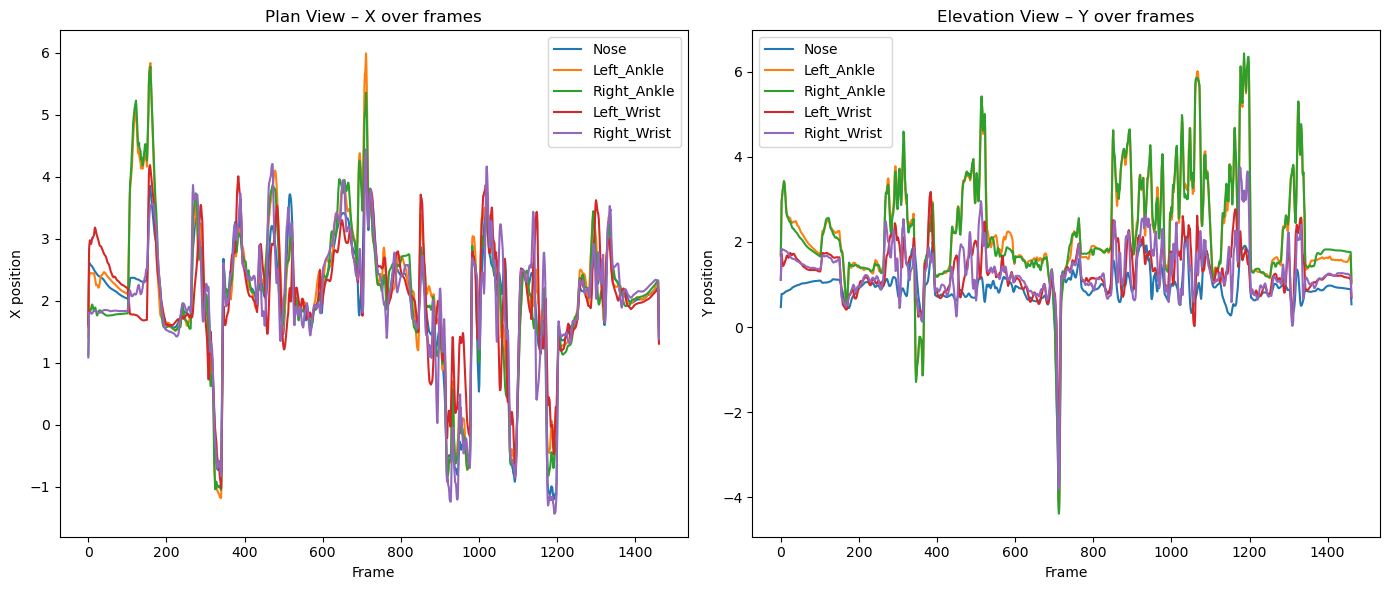

In [19]:
plt.figure(figsize=(14,6))

# Plan view (X)
plt.subplot(1,2,1)
any_plotted = False
for name in landmark_indices:
    xs_m = np.array([m[0] for m in trajectories[name]["meters"]], dtype=float)
    xs_px = np.array([p[0] for p in trajectories[name]["pixels"]], dtype=float)
    series = xs_m if not np.all(np.isnan(xs_m)) else xs_px
    if series.size > 0 and np.any(~np.isnan(series)):
        plt.plot(moving_average_with_interp(series, smooth_k), label=name)
        any_plotted = True
plt.title("Plan View – X over frames")
plt.xlabel("Frame"); plt.ylabel("X position")
if any_plotted:
    plt.legend()

# Elevation view (Y)
plt.subplot(1,2,2)
any_plotted = False
for name in landmark_indices:
    ys_m = np.array([m[1] for m in trajectories[name]["meters"]], dtype=float)
    ys_px = np.array([p[1] for p in trajectories[name]["pixels"]], dtype=float)
    series = ys_m if not np.all(np.isnan(ys_m)) else ys_px
    if series.size > 0 and np.any(~np.isnan(series)):
        plt.plot(moving_average_with_interp(series, smooth_k), label=name)
        any_plotted = True
plt.title("Elevation View – Y over frames")
plt.xlabel("Frame"); plt.ylabel("Y position")
if any_plotted:
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
if overlay:
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # more compatible on Windows
    overlay_path = "kalaripayattu_overlay.avi" # change extension to .avi
    writer = cv2.VideoWriter(overlay_path, fourcc, fps, (W,H))

    
    colors = {"Nose":(0,0,255),
              "Left_Ankle":(0,255,0),
              "Right_Ankle":(255,0,0),
              "Left_Wrist":(255,255,0),
              "Right_Wrist":(0,255,255)}
    
    for fi in range(frame_idx):
        ret, frame = cap.read()
        if not ret: break
        for name in landmark_indices:
            pts = trajectories[name]["pixels"][:fi+1]
            pts_valid = [(int(px), int(py)) for px, py in pts if not np.isnan(px)]
            for i in range(1, len(pts_valid)):
                cv2.line(frame, pts_valid[i-1], pts_valid[i], colors.get(name,(255,255,255)), 2)
            if pts_valid: cv2.circle(frame, pts_valid[-1], 4, colors.get(name,(255,255,255)), -1)
        writer.write(frame)
    
    cap.release()
    writer.release()
    print(f"Overlay video saved: {overlay_path}")


In [ ]:
import pandas as pd

# Prepare data for CSV
data = []
num_frames = len(trajectories["Nose"]["pixels"])

for i in range(num_frames):
    frame_data = {"Frame": i+1}
    for name in trajectories.keys():
        if i < len(trajectories[name]["pixels"]):
            x, y = trajectories[name]["pixels"][i]
            frame_data[f"{name}_X"] = x
            frame_data[f"{name}_Y"] = y
        else:
            frame_data[f"{name}_X"] = None
            frame_data[f"{name}_Y"] = None
    data.append(frame_data)

# Create DataFrame
df = pd.DataFrame(data)

# Save CSV
csv_filename = "kalaripayattu_trajectories.csv"
df.to_csv(csv_filename, index=False)
print(f"Trajectory CSV saved as {csv_filename}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------------
# PARAMETERS
# -------------------------------
csv_filename = "kalaripayattu_trajectories.csv"
output_gif = "kalaripayattu_trails.gif"
trail_length = 30  # last N frames
smooth_k = 5       # smoothing window
fps = 15           # GIF frames per second

# Colors for each landmark
landmark_colors = {
    "Nose": (1, 0, 0),          # red
    "Left_Wrist": (0, 1, 0),    # green
    "Right_Wrist": (0, 0, 1),   # blue
    "Left_Ankle": (1, 0.5, 0),  # orange
    "Right_Ankle": (0.5, 0, 0.5) # purple
}

# Frame dimensions (adjust according to your video)
W = 1280
H = 720

# -------------------------------
# LOAD CSV
# -------------------------------
df = pd.read_csv(csv_filename)
landmark_names = list(landmark_colors.keys())

# Create trajectories dictionary from CSV
trajectories = {}
for name in landmark_names:
    trajectories[name] = {
        "pixels": list(zip(df[f"{name}_X"], df[f"{name}_Y"]))
    }

# -------------------------------
# CREATE FRAMES FOR GIF
# -------------------------------
frames_list = []
num_frames = len(df)

print("Generating GIF frames...")
for i in range(num_frames):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)  # invert y-axis
    ax.axis("off")
    
    for name, color in landmark_colors.items():
        points = trajectories[name]["pixels"]
        trail = points[max(0,i-trail_length):i+1]
        if not trail:
            continue
        xs = [p[0] for p in trail]
        ys = [p[1] for p in trail]
        # Smooth trajectories
        xs = np.convolve(xs, np.ones(smooth_k)/smooth_k, mode='same')
        ys = np.convolve(ys, np.ones(smooth_k)/smooth_k, mode='same')
        # Draw gradient trail
        for j in range(len(xs)-1):
            alpha = (j+1)/len(xs)
            ax.plot(xs[j:j+2], ys[j:j+2], color=(color[0]*alpha, color[1]*alpha, color[2]*alpha), lw=2)
        # Draw current position
        ax.scatter(xs[-1], ys[-1], color='red', s=30)
    
    # Convert figure to image
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames_list.append(Image.fromarray(img))
    plt.close(fig)

# -------------------------------
# SAVE GIF
# -------------------------------
print("Saving GIF...")
frames_list[0].save(
    output_gif,
    save_all=True,
    append_images=frames_list[1:],
    duration=int(1000/fps),  # ms per frame
    loop=0
)

print(f"GIF saved as {output_gif}")


Generating GIF frames...


C:\Users\Dell\AppData\Local\Temp\ipykernel_39592\4017981978.py:73: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
